In [1]:
import datetime as dt
import matplotlib
import numpy as np
from analytics import *
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

In [2]:
%%time
train= pd.read_csv("train_features.csv", low_memory=False, index_col= 'fullVisitorId')
validation= pd.read_csv("validation_features.csv", low_memory=False, index_col= 'fullVisitorId')
test= pd.read_csv("test_features.csv", low_memory=False, index_col= 'fullVisitorId')

CPU times: user 42.1 s, sys: 3.56 s, total: 45.6 s
Wall time: 48.9 s


In [3]:
features = list(train.columns)
features.remove('target')

columns_with_6_months = [c for c in features if "6_months" in c]
columns_without_months = [c for c in features if "months" not in c]

few_features = columns_without_months
more_features = columns_without_months + columns_with_6_months 
all_features = features

In [4]:
relevant_columns = all_features

train = train[relevant_columns + ['target']]
validation = validation[relevant_columns + ['target']]
test = test[relevant_columns] 

X_train = train.drop(columns=['target'])
y_train = train.target

X_validation = validation.drop(columns=['target'])
y_validation = validation.target

In [5]:
%%time
parameters = {
    'min_samples_leaf' : [100, 1000, 2000],
    'max_depth': [50,100, 200],
    'n_estimators': [100, 200],   
    'max_features': ['sqrt']
}

regr = RandomForestRegressor(criterion='mse')
grid = GridSearchCV(regr, parameters, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid.fit(X_train, y_train)
model = grid.best_estimator_

CPU times: user 25min 12s, sys: 13.8 s, total: 25min 26s
Wall time: 1h 31min 40s


In [6]:
mean_test_scores = (-1)*grid.cv_results_['mean_test_score']
mean_train_scores = (-1)*grid.cv_results_['mean_train_score']
A =pd.DataFrame({'mean_test_scores':mean_test_scores, 'mean_train_scores':mean_train_scores})
A.plot()

In [7]:
print "croos validation score", grid.best_score_
print "best parameters:"
print grid.best_params_

croos validation score -0.10129205160911987
best parameters:
{'max_features': 'sqrt', 'n_estimators': 200, 'max_depth': 100, 'min_samples_leaf': 100}


feature importance


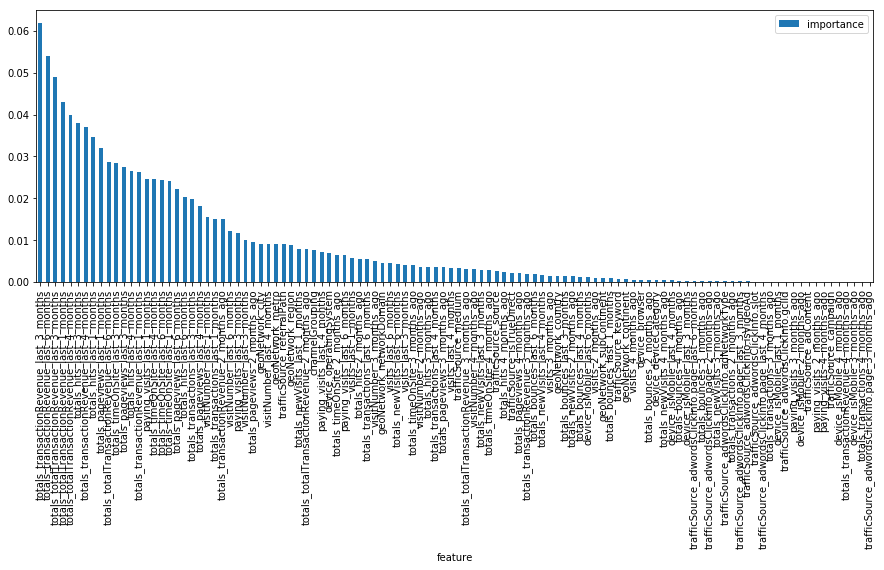

In [8]:
print "feature importance"
feature_importance = pd.DataFrame({'feature': X_train.columns, 'importance':model.feature_importances_}).set_index('feature').sort_values(by=['importance'], ascending=False)
feature_importance[feature_importance.importance>0].plot.bar(figsize=(15,5))

In [9]:
get_validation_report(model, X_train, y_train, X_validation, y_validation)

,train_benchamrk,train_improvement,train_mse,validation_benchmark,validation_improvement,validation_mse
0,0.10312,-3.824387,0.099176,0.110465,-0.331484,0.110099


In [10]:
print "Features not used by the model: "
print list(feature_importance[feature_importance.importance==0].index.values)

Features not used by the model: 
['totals_totalTransactionRevenue_4_months_ago', 'totals_sessionQualityDim_last_4_months', 'trafficSource_adwordsClickInfo.page_4_months_ago', 'totals_sessionQualityDim_3_months_ago', 'totals_sessionQualityDim_last_3_months', 'totals_sessionQualityDim_4_months_ago', 'totals_sessionQualityDim_last_1_months', 'totals_sessionQualityDim_last_6_months', 'totals_sessionQualityDim_2_months_ago', 'trafficSource_adwordsClickInfo.page_last_1_months']


In [11]:
## retrain model for submision
file_name = "results_random_forest_all_features_2.csv"

X = pd.concat([X_train, X_validation], ignore_index=True)
y = pd.concat([y_train, y_validation], ignore_index=True)
grid.fit(X, y)
y_predicted = grid.predict(test)
test['PredictedLogRevenue']= list(y_predicted)
results = test[['PredictedLogRevenue']].reset_index()
results.to_csv(file_name, float_format='%.12f', index=False)